In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')
print(c.ids)
view = c[:]
view.activate()


[0, 1, 2, 3]


In [3]:
%%px --block
from mpi4py import MPI 
import numpy as np

#number of procesess:

comm = MPI.COMM_WORLD
No_processes = comm.Get_size()
process_rank=comm.Get_rank()

#constants

N = 128
dt=0.00001
Niter=110
D=1
h=1./(N-1)
C=D*dt/h**2
a=0
b=0

x = np.linspace(0,1.,N)
#area:

if process_rank==0:    

    U=np.zeros(N)
    U[N//2]=1./h

else: 
    U=np.empty(N)

#subareas:
    
U_local = np.empty((N//No_processes)+2)
comm.Scatter(U, U_local[1:-1])


#computation

if process_rank==0:

    U_local[0]=a

elif process_rank==1:

    U_local[-1]=b    


for i in range(Niter):

    if process_rank==0:
        data0=U_local[-2]
        comm.send(data0, dest=1)
        U_local[-1]=comm.recv(source=1)
        
    elif process_rank==1:
        U_local[0]=comm.recv(source=0)
        data1=U_local[1]
        comm.send(data1, dest=0)
        
        
    U_local[1:-1]=U_local[1:-1]+C*(U_local[2:]+U_local[:-2]-2*U_local[1:-1])

if False:
    if process_rank==0:
        U_local=U_local[1:-1]

    elif process_rank==1:
        U_local=U_local[1:-1]

comm.Gather(U_local[1:-1], U)

if process_rank==0:
    np.savez("Uout",U=U,x=x)



In [4]:
U = view['U'][view['process_rank'][0]]

In [5]:
%config InlineBackend.figure_format = 'png2x'

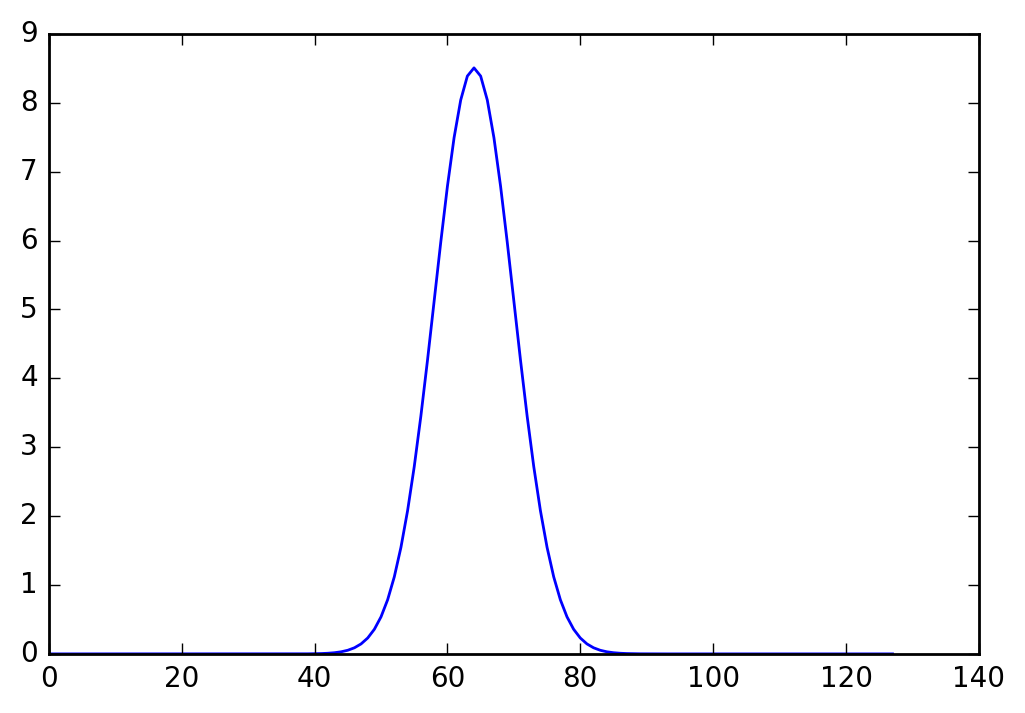

In [6]:
plt.plot(U)


In [45]:
view['process_rank']

[1, 0]

In [60]:
[u.shape for u in view['U_local']]

[(64,), (64,)]

In [61]:
import os
os.environ['HOME']

'/home/users/marcin.kostur'

In [62]:
data = np.load(os.environ['HOME']+'/Uout.npz')

In [63]:
data.files

['x', 'U']

In [64]:
U = data['U']
x = data['x']

In [65]:
U.shape

(128,)

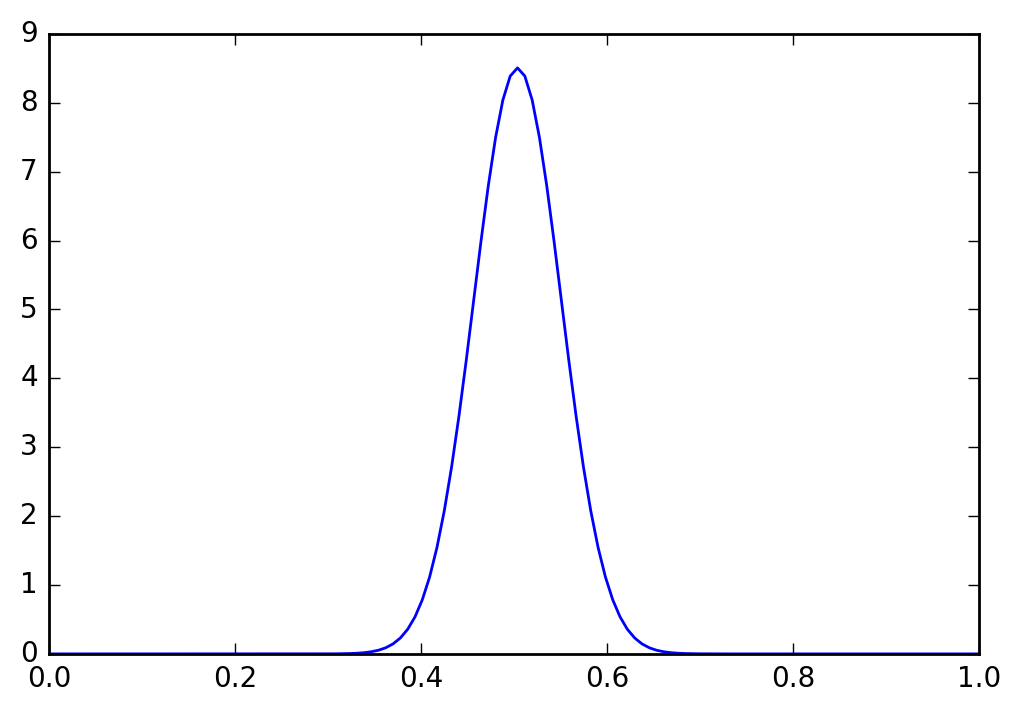

In [66]:
plt.plot(x,U)

In [59]:
%%px --block
from mpi4py import MPI 
comm = MPI.COMM_WORLD
print(comm.Get_size())

[stdout:0] 2
[stdout:1] 2


In [4]:
%%px --block
from mpi4py import MPI 
import numpy as np

#number of procesess:

comm = MPI.COMM_WORLD
No_processes = comm.Get_size()
process_rank=comm.Get_rank()

#constants

N = 128
dt = 0.00002
Niter = 110
D = 1
h = 1./(N-1)
C = D*dt/h**2
a = 1.0
b = 0

x = np.linspace(0,1.,N)
x_local = x.reshape(No_processes,N//No_processes)[process_rank]

#area:

if process_rank==0:    
    U = np.linspace(0,1,N)
    #U[N//2] = 1./h
else: 
    U=np.empty(N)

#subareas:
    
U_local = np.empty((N//No_processes)+2)
comm.Scatter(U, U_local[1:-1])

#computation
Utime = None 
U_local_time = []
# global BC
if process_rank==0:
    Utime = []
    U_local[0]=a

elif process_rank==1:
    U_local[-1] = b   
    
L_bulk = 1
L_ghost = 0
R_bulk = -2
R_ghost = -1

for i in range(Niter):
    
    if process_rank<(No_processes-1):
        data0 = U_local[R_bulk]
        comm.send(data0, dest=process_rank+1)
        U_local[R_ghost] = comm.recv(source=process_rank+1)
        
    if process_rank>0:
        U_local[L_ghost] = comm.recv(source=process_rank-1)
        data0 = U_local[L_bulk]
        comm.send(data0, dest=process_rank-1)
        
    U_local[1:-1] = U_local[1:-1]+C*(U_local[2:]+U_local[:-2]-2*U_local[1:-1])

    comm.Gather(U_local[1:-1], U)
    if process_rank==0:
        Utime.append(U.copy())

    U_local_time.append(U_local[1:-1])


In [23]:
%time Utime = view['Utime'][view['process_rank'].index(0)]

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 17.4 ms


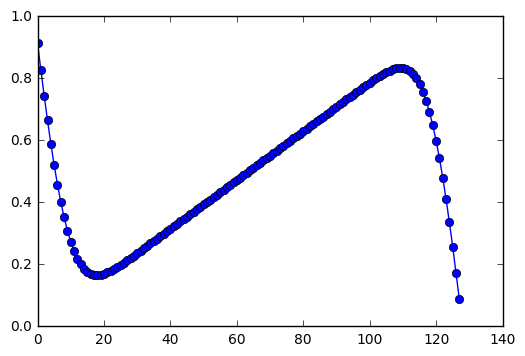

In [25]:
from IPython.display import display,clear_output
import time
fig, ax = plt.subplots()
for i,U in enumerate(Utime[::]):
    clear_output(wait=True)
    ax.cla()
    ax.plot(U,'o-')
    
    display(fig)
plt.close()

In [7]:
%time U_local_time = view['U_local_time']
%time x_local = view['x_local']

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 9.6 ms
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.42 ms


In [8]:
view['No_processes'][0]

4

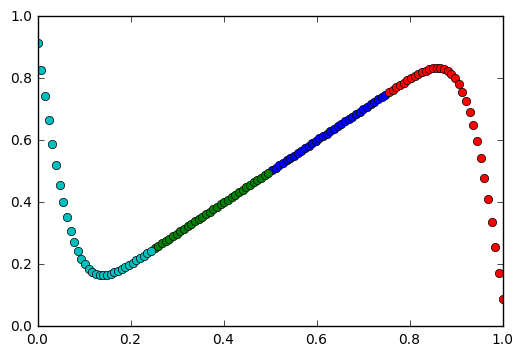

In [9]:
for i in range(view['No_processes'][0]):
    plt.plot(x_local[i],U_local_time[i][74],'o')
    